In [19]:
import os
import pickle 
import random
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import torch

import sys
sys.path.insert(0, '..')
from src.data import TimeSeries
from src.methods import rl
from src.environment import TimeSeriesEnv

In [2]:
# GLOBALS
SEED = 3141
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
train_ts = TimeSeries.from_csv(
    'pandas',
    '../data/blood-refrigerator/train.csv'
)
valid_ts = TimeSeries.from_csv(
    'pandas',
    '../data/blood-refrigerator/val.csv'
)
test_ts = TimeSeries.from_csv(
    'pandas',
    '../data/blood-refrigerator/test.csv'
)

train_ts.parse_datetime('timestamp')
valid_ts.parse_datetime('timestamp')
test_ts.parse_datetime('timestamp')

train_ts.split_by_day()
valid_ts.split_by_day()
test_ts.split_by_day()

In [4]:
temp = pd.concat(
    train_ts.time_series[k].drop(
        columns=['timestamp','PW_0.5h','date','time']
    ) for k in train_ts.time_series.keys()
)

FEATURE_COLS = [
    c for c in temp.columns if np.std(temp[c])!=0
]
LABEL_COL = 'PW_0.5h'

temp = None
del temp
len(FEATURE_COLS)

12

In [5]:
train_env = TimeSeriesEnv(train_ts, FEATURE_COLS, LABEL_COL)
valid_env = TimeSeriesEnv(valid_ts, FEATURE_COLS, LABEL_COL)
test_env = TimeSeriesEnv(test_ts, FEATURE_COLS, LABEL_COL)

In [6]:
alpha_stop = rl.NeuralNetGuidedMCTS(
    in_dim=len(FEATURE_COLS),
    hid_dim=64,
    save_dir='../results/rl/br',
    n_actions=2,
    n_sim=10,
    lr=1e-3,
    weight_decay=0.1,
    gamma=0.999,
    bsz=32,
    device='cpu'
)

In [7]:
train_actions, train_rewards = alpha_stop.train(5, train_env, valid_env)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/60166 [00:00<?, ?it/s]

Better mean reward! Saving...


  0%|          | 0/60166 [00:00<?, ?it/s]

Better mean reward! Saving...


  0%|          | 0/60166 [00:00<?, ?it/s]

  0%|          | 0/60166 [00:00<?, ?it/s]

  0%|          | 0/60166 [00:00<?, ?it/s]

In [8]:
for (dt, a) in train_actions.items():
    rs = train_rewards[dt]
    print(dt, sum(a), sum(rs))

2022-10-31 0 1.0500000000000007
2022-11-01 0 25.300000000001155
2022-11-02 0 25.310000000001157
2022-11-03 0 25.300000000001155
2022-11-04 0 25.310000000001157
2022-11-05 0 25.300000000001155
2022-11-06 0 25.300000000001155
2022-11-07 0 22.630000000000738
2022-11-08 1 -74.70999999998706
2022-11-09 0 1.340000000000001
2022-11-10 1 -74.70999999998706
2022-11-11 0 25.310000000001157
2022-11-12 0 -1406.230000000009
2022-11-13 0 25.300000000001155
2022-11-14 0 25.310000000001157
2022-11-15 0 25.300000000001155
2022-11-16 0 -4440.6299999997955
2022-11-17 0 -1515.2500000000025
2022-11-18 0 -1353.2100000000025
2022-11-19 0 25.300000000001155
2022-11-20 0 25.300000000001155
2022-11-21 0 25.310000000001157
2022-11-22 0 -5540.749999999797
2022-11-23 0 25.310000000001157
2022-11-24 1 -9986.41


In [9]:
test_actions, test_rewards = alpha_stop.run(test_env)

In [20]:
pickle.dump(train_actions, open(os.path.join('../results/rl/br','train_actions.pkl'), 'wb'))
pickle.dump(train_rewards, open(os.path.join('../results/rl/br','train_rewards.pkl'), 'wb'))
pickle.dump(test_actions, open(os.path.join('../results/rl/br','test_actions.pkl'), 'wb'))
pickle.dump(test_rewards, open(os.path.join('../results/rl/br','test_rewards.pkl'), 'wb'))

<Axes: >

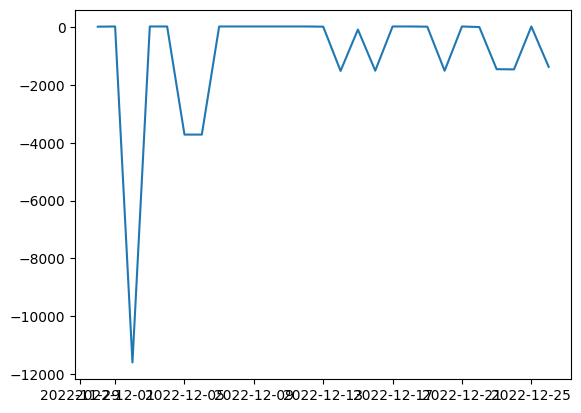

In [13]:
sns.lineplot(
    {dt: sum(r) for dt, r in test_rewards.items()}
)